# SciKit Learn Support Vector Machines regression

# Imports

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Read data

In [2]:
# dataset part 1
dataset = pd.read_csv('../../../dataset/smog_part1.csv', index_col = 0)

In [3]:
dataset = dataset[['pm25_x', 'pm25_y', 'temperatureSht', 'humiditySht', 'pressure']]
dataset = dataset[dataset['humiditySht'] >= 60]

dataset.head()

,pm25_x,pm25_y,temperatureSht,humiditySht,pressure
0,19.0,13.8,6.1,72,986
1,16.7,14.4,5.9,74,986
2,21.8,15.1,5.7,75,986
3,21.8,18.0,5.7,76,986
4,25.0,19.0,5.5,77,986


# Train and test split

Split data for train and test sets and normalze

In [4]:
Y = dataset['pm25_x'].to_numpy().reshape(-1, 1)
X = dataset.drop('pm25_x', axis = 1).to_numpy()

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 0)

In [6]:
scaler = preprocessing.StandardScaler().fit(x_train)
y_scaler = max(y_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

y_train = y_train / y_scaler
y_test = y_test / y_scaler

# SKLearn SVR

In [7]:
svr = SVR()

svr.fit(x_train,y_train.ravel())

train_dataset_score = svr.score(x_train,y_train)
test_dataset_score = svr.score(x_test, y_test)

print('R2 on train dataset: ', round(train_dataset_score * 100, 2))
print('R2 on test dataset: ', round(test_dataset_score * 100, 2))

R2 on train dataset:  49.91
R2 on test dataset:  49.36


# HalvingGridSearchCV tuner

In [8]:
param_grid = {
    'C': [0.01, 0.1]+[i for i in range(1, 12)],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [i for i in range(12)],
    'gamma': ['scale', 'auto'],
    'tol': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'shrinking': [True, False],
    'cache_size': [2**i for i in range(0, 12, 2)],
}

In [9]:
param_grid = {
    'C': [2],
    'kernel': ['linear'],
    'degree': [1, 2, 4, 8, 16, 32, 64, 128, 256],
    'gamma': ['scale', 'auto'],
    'tol': [0.001],
    'epsilon': [0.001],
    'shrinking': [True]
}

In [10]:
grid_cv_svr = HalvingGridSearchCV(SVR(),
                           param_grid,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
grid_cv_svr

HalvingGridSearchCV(estimator=SVR(), n_jobs=-1,
                    param_grid={'C': [2],
                                'degree': [1, 2, 4, 8, 16, 32, 64, 128, 256],
                                'epsilon': [0.001], 'gamma': ['scale', 'auto'],
                                'kernel': ['linear'], 'shrinking': [True],
                                'tol': [0.001]},
                    verbose=1)

In [11]:
%%time
grid_cv_svr.fit(x_train,y_train.ravel())

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1660
max_resources_: 14946
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 1660
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 6
n_resources: 4980
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 14940
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 10min 33s, sys: 816 ms, total: 10min 33s
Wall time: 21min 36s


HalvingGridSearchCV(estimator=SVR(), n_jobs=-1,
                    param_grid={'C': [2],
                                'degree': [1, 2, 4, 8, 16, 32, 64, 128, 256],
                                'epsilon': [0.001], 'gamma': ['scale', 'auto'],
                                'kernel': ['linear'], 'shrinking': [True],
                                'tol': [0.001]},
                    verbose=1)

In [12]:
print('Best parameters: ', grid_cv_svr.best_params_)

Best parameters:  {'C': 2, 'degree': 256, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True, 'tol': 0.001}


In [13]:
best_svr_model = grid_cv_svr.best_estimator_

y_pred = best_svr_model.predict(x_test) * y_scaler

r2 = r2_score(y_test * y_scaler,y_pred) * 100
mse =  mean_squared_error(y_test * y_scaler, y_pred)
mae = mean_absolute_error(y_test * y_scaler, y_pred)

print('R2: ', r2)
print('MSE: ',mse)
print('MAE: ',mae)

R2:  82.32444152986218
MSE:  9.2567020615569
MAE:  1.3398854750952827


# Searching for parameters step by step

2nd approach: to compare parameters step by step to find the best

Best found parameter: linear


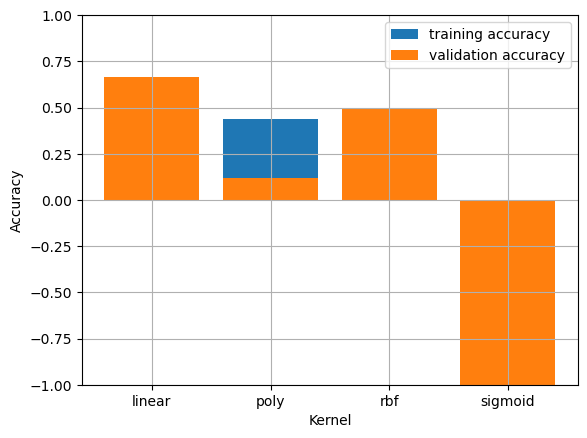

In [9]:
value_range = ['linear', 'poly', 'rbf', 'sigmoid']
training_score = []
validation_score = []

for val in value_range:
    model = SVR(kernel=val)
    model.fit(x_train, y_train.ravel())
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
    
plt.bar(value_range, training_score, label='training accuracy')
plt.bar(value_range, validation_score, label='validation accuracy')

best_kernel = value_range[validation_score.index(max(validation_score))]
print(f'Best found parameter: {best_kernel}')

plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.ylim([-1, 1])
plt.legend()
plt.grid()
plt.show()

Best found parameter: 1


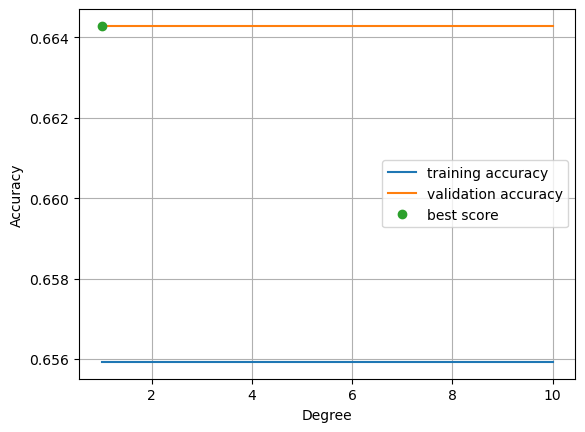

In [10]:
value_range = [i for i in range(1, 11)]
training_score = []
validation_score = []

for val in value_range:
    model = SVR(kernel=best_kernel,
               degree=val)
    model.fit(x_train, y_train.ravel())
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_degree = value_range[validation_score.index(best_validation_score)]
plt.plot(best_degree, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_degree}')

plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 0


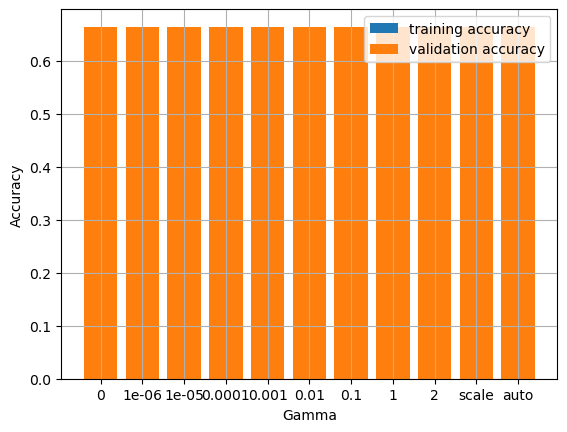

In [11]:
value_range = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 'scale', 'auto']
training_score = []
validation_score = []

for val in value_range:
    model = SVR(kernel=best_kernel,
               degree=best_degree,
               gamma=val)
    model.fit(x_train, y_train.ravel())
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
    
plt.bar([str(x) for x in value_range], training_score, label='training accuracy')
plt.bar([str(x) for x in value_range], validation_score, label='validation accuracy')

best_gamma = value_range[validation_score.index(max(validation_score))]
print(f'Best found parameter: {best_gamma}')

plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 1e-05


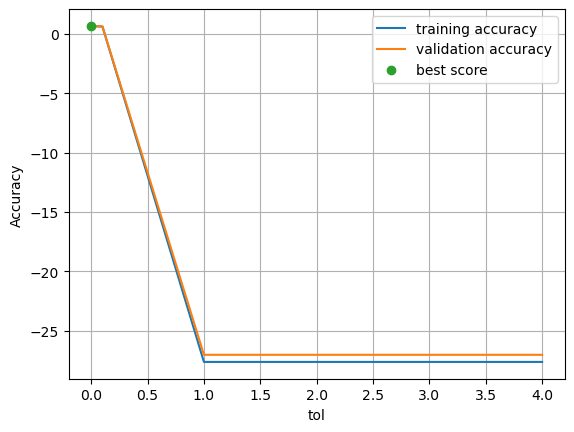

In [12]:
value_range = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 4]
training_score = []
validation_score = []

for val in value_range:
    model = SVR(kernel=best_kernel,
               degree=best_degree,
               gamma=best_gamma,
               tol=val)
    model.fit(x_train, y_train.ravel())
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
    
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_tol = value_range[validation_score.index(best_validation_score)]
plt.plot(best_tol, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_tol}')

plt.xlabel('tol')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 4


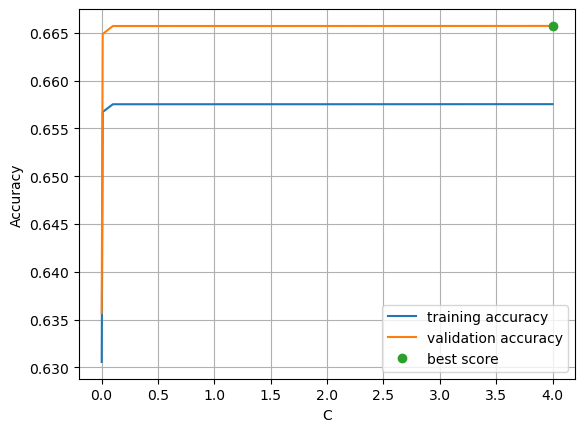

In [13]:
value_range = [0.001, 0.01, 0.1] + [2**i for i in range(3)]
training_score = []
validation_score = []

for val in value_range:
    model = SVR(kernel=best_kernel,
               degree=best_degree,
               gamma=best_gamma,
               tol=best_tol,
               C=val)
    model.fit(x_train, y_train.ravel())
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_c = value_range[validation_score.index(best_validation_score)]
plt.plot(best_c, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_c}')

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

1e-06 0.8231493950903456
1e-05 0.8231546299411706
0.0001 0.8231769444653749
0.001 0.8231168898718674
0.01 0.8271300053945598
0.1 0.6657089872135286
1 -27.03149282711967
Best found parameter: 0.01


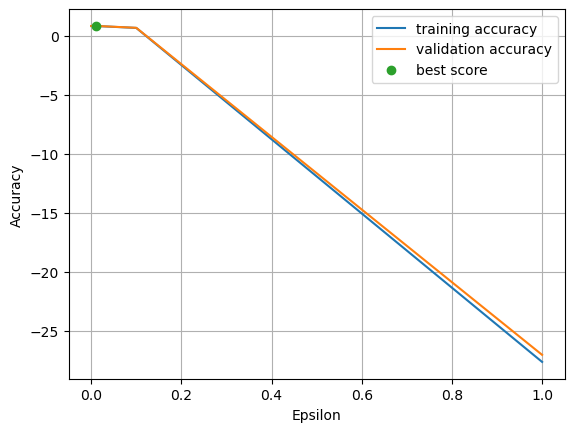

In [14]:
value_range = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
training_score = []
validation_score = []

for val in value_range:
    model = SVR(kernel=best_kernel,
               degree=best_degree,
               gamma=best_gamma,
               tol=best_tol,
               C=best_c,
               epsilon=val)
    model.fit(x_train, y_train.ravel())
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
    print(val, model.score(x_test, y_test))
    
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_epsilon = value_range[validation_score.index(best_validation_score)]
plt.plot(best_epsilon, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_epsilon}')

plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: True


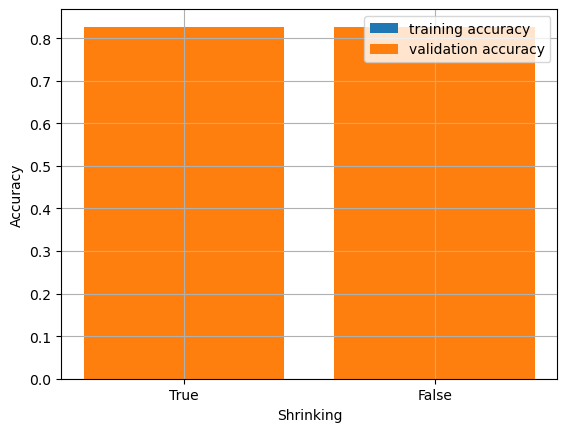

In [15]:
value_range = [True, False]
training_score = []
validation_score = []

for val in value_range:
    model = SVR(kernel=best_kernel,
               degree=best_degree,
               gamma=best_gamma,
               tol=best_tol,
               C=best_c,
               epsilon=best_epsilon,
               shrinking=val)
    model.fit(x_train, y_train.ravel())
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
    
plt.bar([str(x) for x in value_range], training_score, label='training accuracy')
plt.bar([str(x) for x in value_range], validation_score, label='validation accuracy')

best_shrinking = value_range[validation_score.index(max(validation_score))]
print(f'Best found parameter: {best_shrinking}')

plt.xlabel('Shrinking')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [9]:
svr = SVR(kernel='linear',
           tol=0.00001,
           C=16,
           epsilon=0.01,
           shrinking=True)

svr.fit(x_train,y_train.ravel())

train_dataset_score = svr.score(x_train,y_train)
test_dataset_score = svr.score(x_test, y_test)

print('R2 on train dataset: ', round(train_dataset_score * 100, 2))
print('R2 on test dataset: ', round(test_dataset_score * 100, 2))

R2 on train dataset:  82.18
R2 on test dataset:  82.71


In [10]:
y_pred = svr.predict(x_test) * y_scaler

r2 = r2_score(y_test * y_scaler,y_pred) * 100
mse =  mean_squared_error(y_test * y_scaler, y_pred)
mae = mean_absolute_error(y_test * y_scaler, y_pred)

print('R2: ', r2)
print('MSE: ',mse)
print('MAE: ',mae)

R2:  82.71066235717682
MSE:  9.054437950102683
MAE:  1.3575739953782116
